In [215]:
%load_ext autoreload
%autoreload 2

import pickle
import soundfile as sf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from croac.pond.digest import digest
from croac.pond.phrase import Phrase, Song
from croac.pond import Pond
from croac.array import DelayArray
from croac.model import PhasedArrayModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data, samplerate = sf.read('notebooks/frog_songs/Northern-Leopard-Frog.wav')

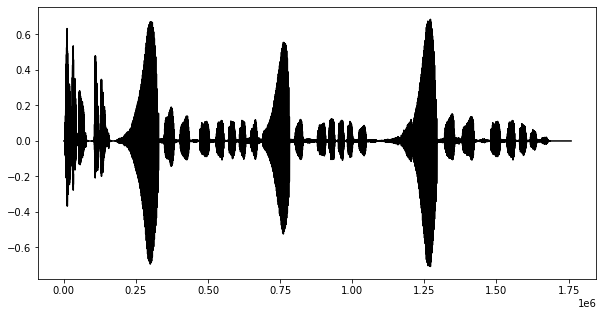

In [3]:
plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(0, data.shape[0], 1), y=data[:,0], color='black');

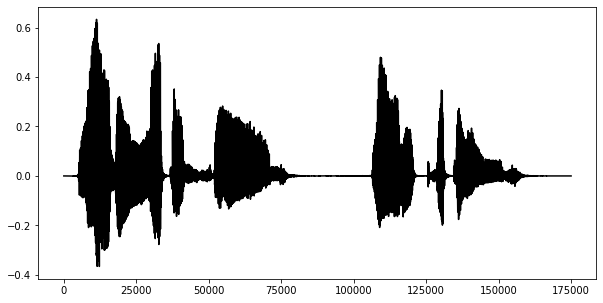

In [4]:
N = 175000
plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(0, N, 1), y=data[:N,0], color='black');

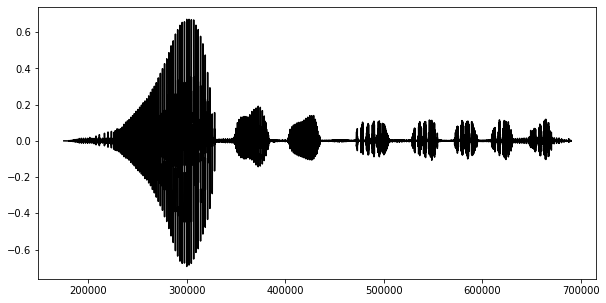

In [5]:
M, N = 175000, 690000
plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(M, N, 1), y=data[M:N,0], color='black');

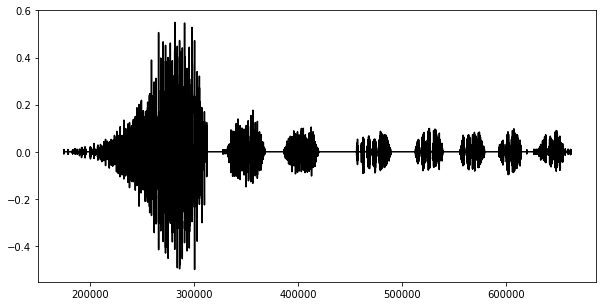

In [6]:
M, N = 175000, 690000
info = list(
    digest(data[M:N,0], freq_resolution=44.1*3, noise_percentile=0.9)
)
notes, pauses, shapes = [], [], []
for note, pause in info:
    notes.append(note)
    pauses.append(pause)
    shapes.append({'amplitude': 2.0})

phrase = Phrase(notes, pauses, shapes)

sound = phrase.listen()

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(M, M+sound.shape[0], 1), y=sound, color='black');

In [7]:
sf.write('Fake-Northern-Leopard-Frog.wav', sound, samplerate)

In [8]:
song = Song([phrase], [0], [{}])

In [9]:
with open('Northern-Leopard-Frog.pkl', 'wb') as fh:
    pickle.dump(song, fh)

Smallest wavelength of interest to us here would be that corresponding to 20kHz. 343/20000 ~ 2cm wavelength. The largest wavelength of interest is 132Hz. 323/132 ~ 2.5m so our spacing needs to be between about 1m and 1cm. Let's do 2.5cm spacing.

In that case if we have an array of say 20 elements we've got 2.5cm * 19 = 0.475 m antenna which we'll keep linear this time around. 

2 D^2 / w gives us our far field condition. 0.45/w. For the larger wavelengths this is going to be no problem. What about our 10kHz? For that w = 0.0343 which gives us a far field conditions of 0.45/0.0343 ~ 13.12 meters. Yea this is going to be way too close, but oh well. Let's see what happens. 

This all makes me think it's extremely important to build an antenna to the range of the frogs in question. 

But let's see what happens :) 

In [196]:
position = np.array([0, 1, 0]) # 0 degrees
position = np.array([1, 1, 0]) # 45 degrees
pond = Pond([song], [position], [np.array([-0.2375 + (i * 0.025), 0, 0]) for i in range(20)])

In [197]:
signals = pond.listen()

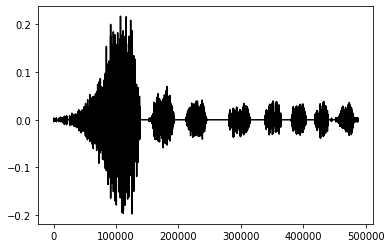

In [198]:
sns.lineplot(x=np.arange(0, signals[0].shape[0], 1), y=signals[0], color='black');

Now it's time to time delay these suckers in order to sweep across the steering angles. Okay so in this 2d case I know my spatial "delay" is m * d * sin(theta). To create such a spatial delay in time I simply need to figure out how much time is covered in that distance. t * speed = d -> t = d / speed. So for example if I have a delay of 2.5 * 0.5 = 1.25cm = 0.0125m then my time delay is 0.036 milliseconds. Now my sample rate is 44100 samples per second which means I can delay by at minimum 0.023 milliseconds. So this is going to be a very rough approximation of delay. 

In [199]:
step = 0.25
darray = DelayArray(
    np.array([-0.2375 + (i * 0.025) for i in range(20)]), 
    np.array([0. for i in range(20)]),
    np.arange(-np.pi/2, np.pi/2, step),
    np.zeros(1),
    44100
)
print(darray.delay_bounds)

(-31, 31)


In [200]:
s = 100000
N = 1000
trunc_signals = np.array([
    signal[s:s+N+sum(abs(b) for b in darray.delay_bounds)]
    for signal in signals
])
print(sum(abs(trunc_signals[2,:])))
trunc_signals.shape

26.709220742575926


(20, 1062)

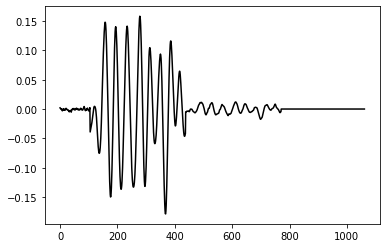

In [201]:
sns.lineplot(x=np.arange(0, trunc_signals.shape[1], 1), y=trunc_signals[0,:], color='black');

In [202]:
darray.ingest_signals(trunc_signals)

In [203]:
darray.sweep()
swept_signals = darray.result
swept_signals.shape

(13, 1, 1000)

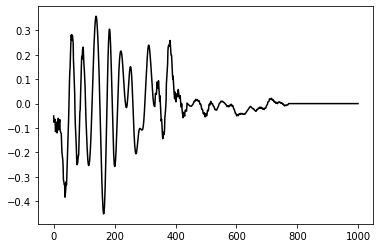

In [204]:
sns.lineplot(x=np.arange(0, swept_signals.shape[2], 1), y=swept_signals[0,0,:], color='black');

In [205]:
darray.decompose()
darray.filter_frequencies()
decomp = darray.filtered_decomposition
print(decomp.shape)

(13, 1, 500)


8


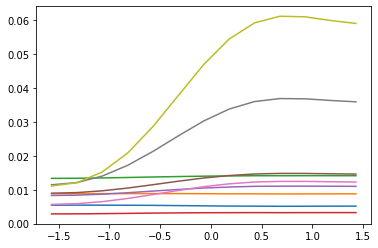

In [206]:
x = darray.theta[:,0,0]
for i in range(decomp.shape[2]):
    y = decomp[:,0,i]
    if np.sum(y) == 0:
        continue
    sns.lineplot(x=x, y=y);
    if np.sum(y) > 0.5:
        print(i)
        break

In [207]:
frequencies = np.arange(0, 500, 1) * 44100 / 1000
343/frequencies[7]

1.1111111111111112

In [208]:
model = PhasedArrayModel(
    omega=343/frequencies[7],
    M=20,
    N=1,
    d_x=0.025,
    d_y=0,
    S=1,
    D=1,
    theta_res=0.25,
    phi_res=0.25,
)

In [209]:
X = []
y = []
for i in range(decomp.shape[0]):
    for j in range(decomp.shape[1]):
        X.append([darray.theta[i,j,0], darray.phi[i,j,0]])
        y.append(decomp[i,j,7])
X = np.array(X)
y = np.array(y)
y *= y
y /= np.max(y)
print(X)
print(y)

[[-1.57079633  0.        ]
 [-1.32079633  0.        ]
 [-1.07079633  0.        ]
 [-0.82079633  0.        ]
 [-0.57079633  0.        ]
 [-0.32079633  0.        ]
 [-0.07079633  0.        ]
 [ 0.17920367  0.        ]
 [ 0.42920367  0.        ]
 [ 0.67920367  0.        ]
 [ 0.92920367  0.        ]
 [ 1.17920367  0.        ]
 [ 1.42920367  0.        ]]
[0.0965199  0.10766364 0.14476185 0.21706722 0.3336548  0.4928428
 0.67381314 0.83876202 0.95246902 1.         0.99619406 0.97010403
 0.94866636]


In [210]:
model.fit(X, y)

 40%|████      | 4/10 [00:01<00:01,  3.62it/s]


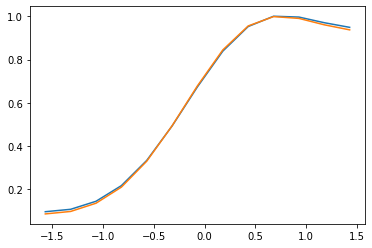

In [211]:
sns.lineplot(x=X[:,0], y=y);
sns.lineplot(x=X[:,0], y=model.P);

In [212]:
np.degrees(model.source_theta)

array([42.70652547])

In [216]:
rows = []
for i in tqdm(range(decomp.shape[2])):
    if np.sum(decomp[:,:,i]) == 0:
        continue
    freq = frequencies[i]
    model = PhasedArrayModel(
        omega=343/freq,
        M=20,
        N=1,
        d_x=0.025,
        d_y=0,
        S=1,
        D=1,
        theta_res=0.25,
        phi_res=0.25,
    )
    X = []
    y = []
    for i in range(decomp.shape[0]):
        for j in range(decomp.shape[1]):
            X.append([darray.theta[i,j,0], darray.phi[i,j,0]])
            y.append(decomp[i,j,7])
    X = np.array(X)
    max_amp = np.max(y)
    y = np.array(y) / max_amp
    y *= y
    model.fit(X, y)
    rows.append({
        'frequency': freq,
        'theta': model.source_theta[0],
        'amplitude': model.a[0] * max_amp
    })
df = pd.DataFrame(rows)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


In [217]:
df

,frequency,theta,amplitude
0,0.0,0.179204,0.001420
1,44.1,1.433418,0.001476
2,88.2,0.942710,0.001476
3,132.3,1.212422,0.001623
4,176.4,1.501339,0.001771
5,220.5,1.250596,0.001845
6,264.6,0.818439,0.001822
7,308.7,0.745369,0.001845
8,352.8,0.479008,0.001845
9,396.9,0.475130,0.001918
